*******1000 units, dropout prob = 0 ********
init layer [1000, 10]
self.learningrate =  0.005
best test err 0.0748898 epoch index 44
best valid err 0.062 epoch index 26
train error at best valid index 0.00999999
final test err 0.0840675
final valid err 0.08
best test loss 0.307538 epoch index 7
best valid loss 0.253768 epoch index 8
final test err 0.557057
final valid err 0.526827
$$$$$$$$$$$$$$$ in plot fig$$$$$$$$$$$$$$$$$
(2, 50)
*******1000 units, dropout prob = 0.5 ********
init layer [1000, 10]
self.learningrate =  0.005
best test err 0.0877386 epoch index 33
best valid err 0.077 epoch index 20
train error at best valid index 0.054
final test err 0.0881057
final valid err 0.088
best test loss 0.342084 epoch index 11
best valid loss 0.295145 epoch index 13
final test err 0.498138
final valid err 0.480426
$$$$$$$$$$$$$$$ in plot fig$$$$$$$$$$$$$$$$$
(2, 50)


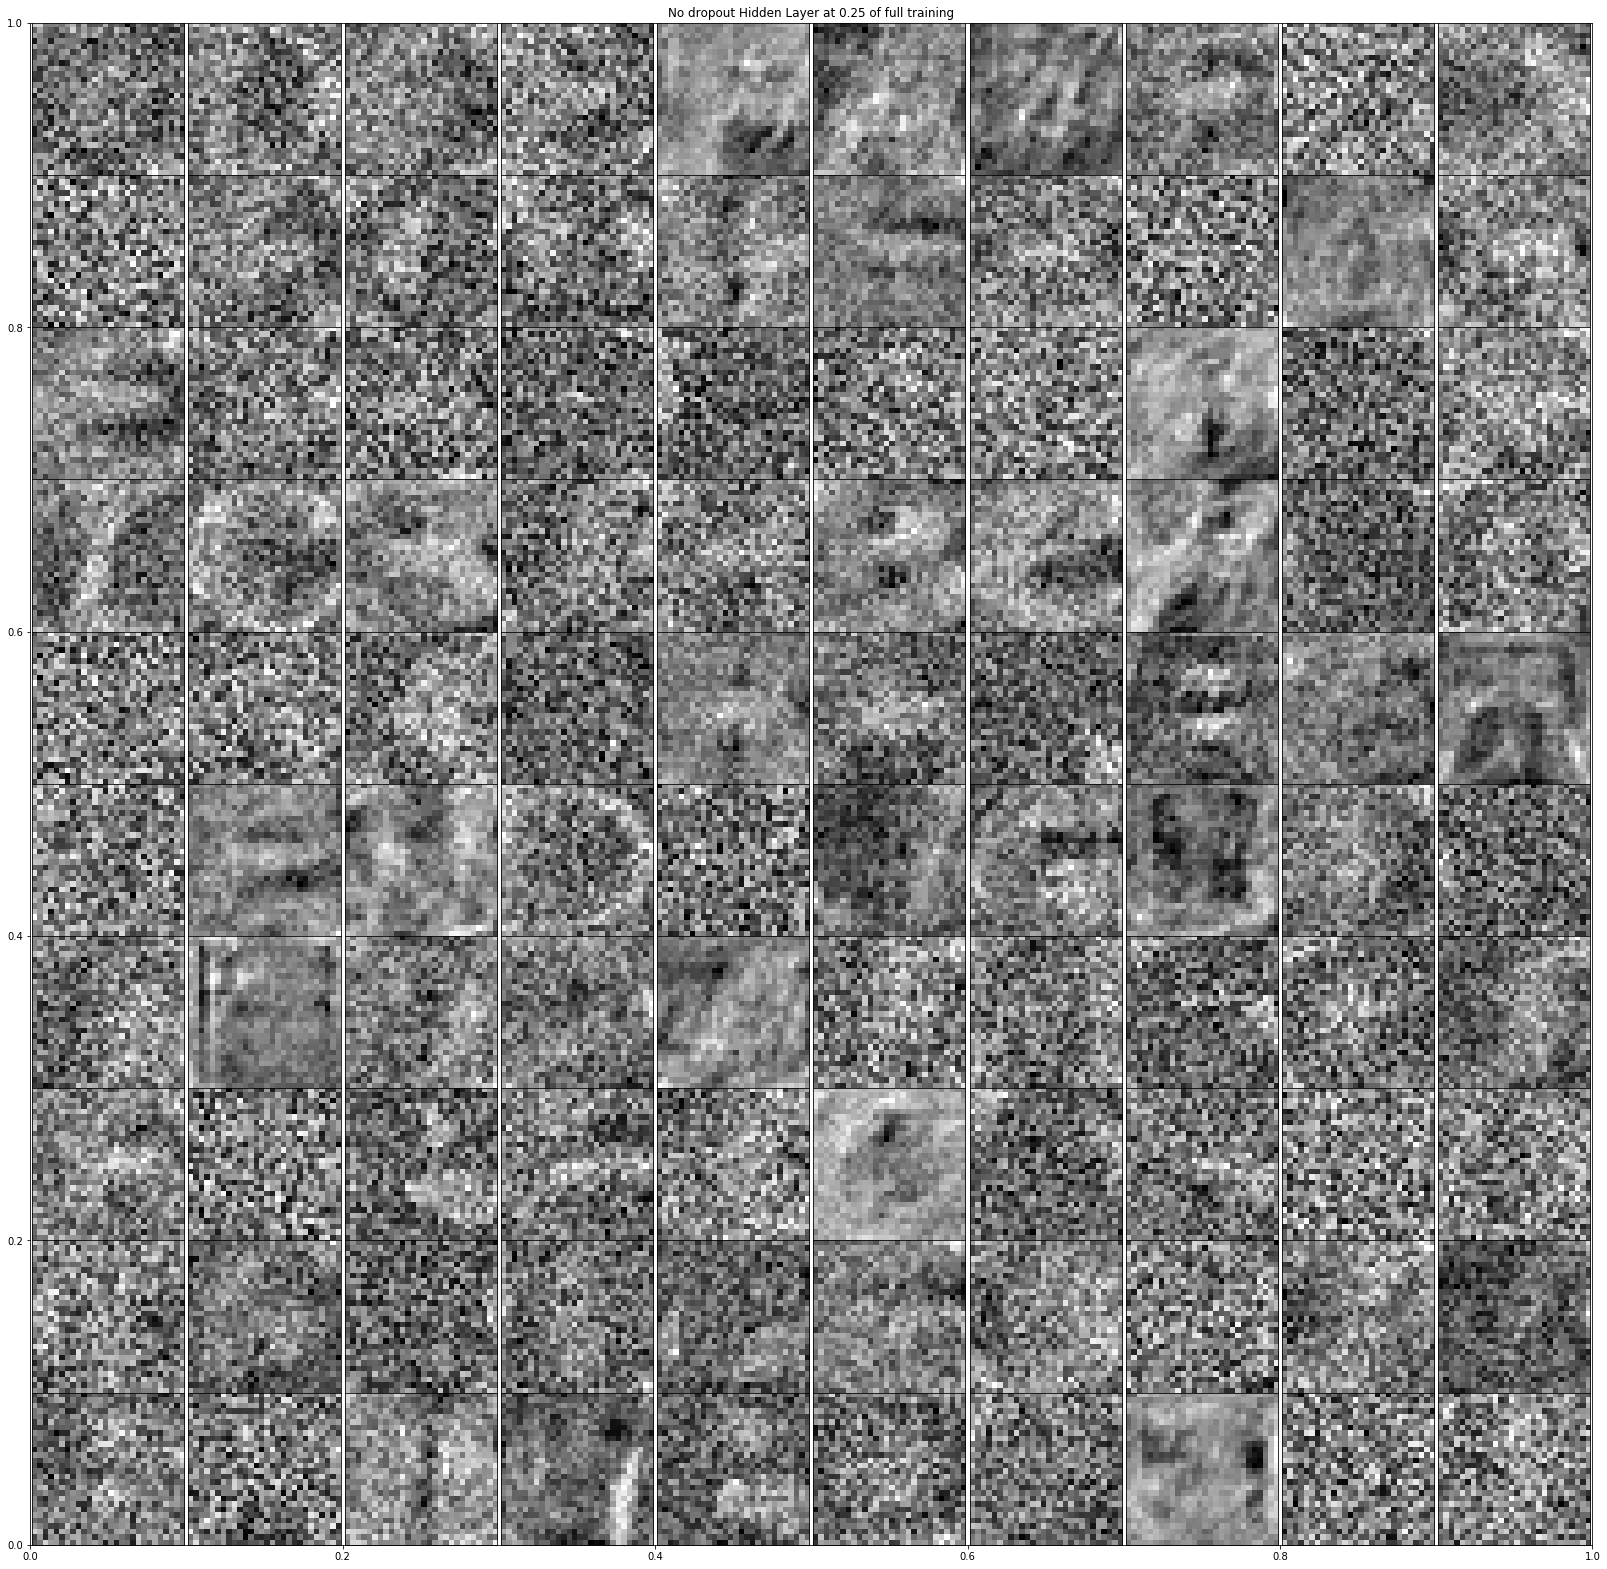

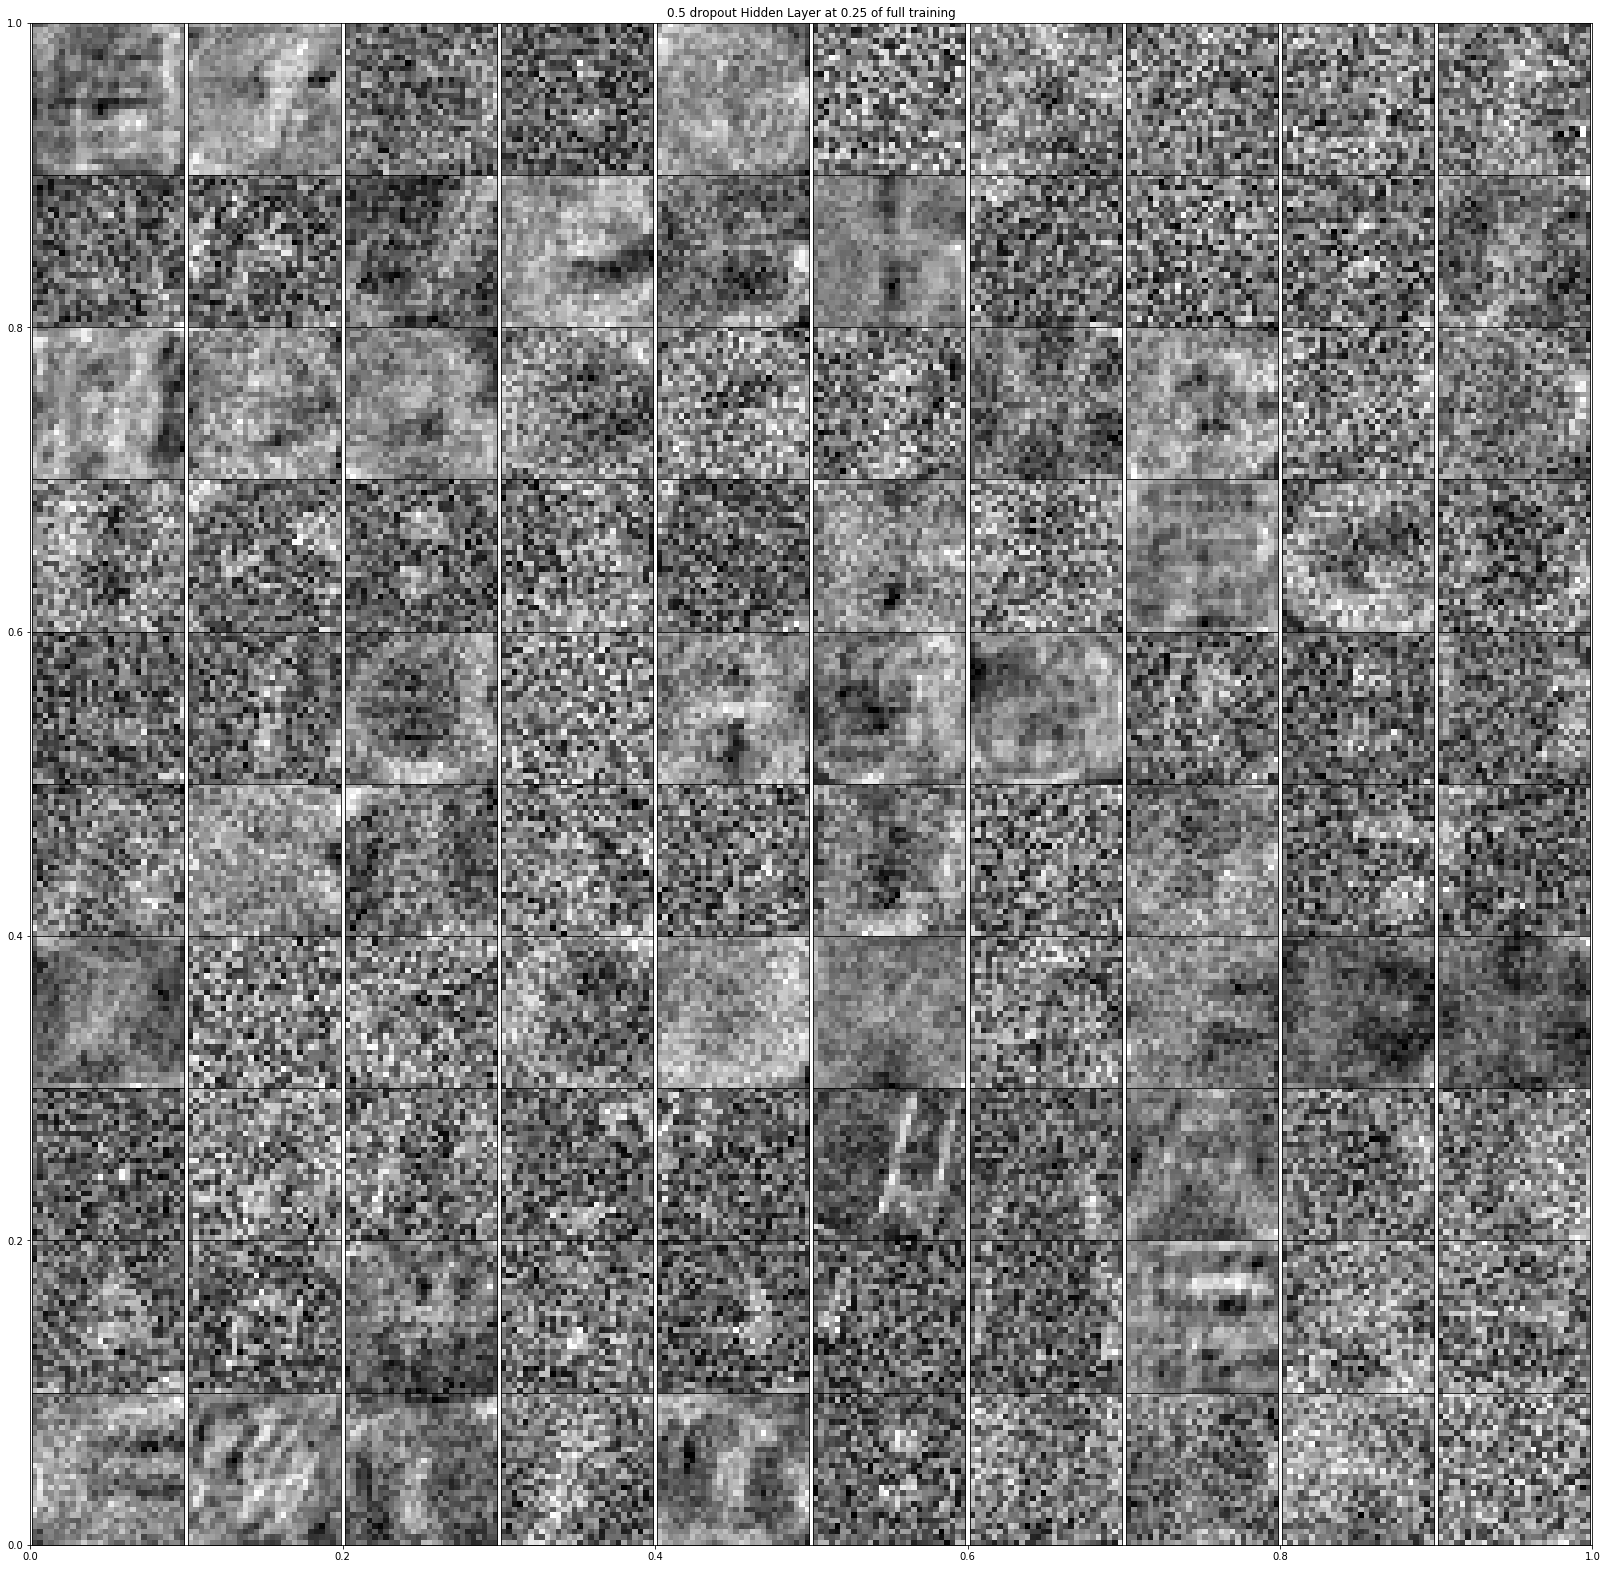

In [9]:
import tensorflow as tf
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import math


def hyperParamGen():
    #random sampes using numpy
    logLearningRate = np.random.uniform(-7.5, -4.5)
    print("logLearningRate", logLearningRate)
    learningRate = np.exp(logLearningRate)
    print("learningRate", learningRate)
    numLayers = np.random.random_integers(1, 5)
    #print("numLayers", numLayers)
    #numHiddenUnits = np.random.random_integers(100, 500)
    #print("numHiddenUnits", numHiddenUnits)
    
    numHiddenUnits = []
    for i in range(0, numLayers):
        numUnit = np.random.random_integers(100, 500)
        numHiddenUnits.append(numUnit)
    
    logWeightedDecay = np.random.uniform(-9, -6)
    print("logWeightedDecay", logWeightedDecay)
    weightedDecay = np.exp(logWeightedDecay)
    print("weightedDecay", weightedDecay)
    dropOut = np.random.random_integers(0, 1) # 0 or 1
    print("dropOut", dropOut)
    
    return learningRate, numLayers, numHiddenUnits, weightedDecay, dropOut

class loadData:
    def __init__(self):
        self.flatten = True
        self.addOnes = False
        
        self.data_path = '/Users/vikuo/Documents/GitHub/ece521/assi/A3/notMNIST.npz'
    def arrFlatten(self, arr):
        '''
        type np array
        '''
        dataDim1, dum1, dum2 = arr.shape
        dum_sq = dum1 * dum2
        arr = np.reshape(arr, [ dataDim1 ,dum_sq ])
        return arr   
    
    def convertTarget(self, targetValues):
        numClasses = np.max(targetValues) + 1
        return np.eye(numClasses)[targetValues]
    
    def loadNumData(self):
        with np.load(self.data_path) as data:
            Data, Target = data ["images"], data["labels"]
            np.random.seed(521)
            randIndx = np.arange(len(Data))
            np.random.shuffle(randIndx)
            Data = Data[randIndx]/255.
            
            if self.flatten:
                Data = self.arrFlatten(Data)
            
            Target = Target[randIndx]
            trainData, trainTarget = Data[:15000], Target[:15000]
            validData, validTarget = Data[15000:16000], Target[15000:16000]
            testData, testTarget = Data[16000:], Target[16000:]
            
            trainTarget = self.convertTarget(trainTarget)
            validTarget = self.convertTarget(validTarget)
            testTarget = self.convertTarget(testTarget)
 
        return trainData, trainTarget, validData, validTarget, testData, testTarget

class BatchSampler(object):
    '''
    A (very) simple wrapper to randomly sample batches without replacement.
    '''
    
    def __init__(self, data, targets, batch_size):
        self.num_points = data.shape[0]
        self.features = data.shape[1]
        self.data = data
        self.targets = targets
        self.batch_size = batch_size
        self.indices = np.arange(self.num_points)

    def random_batch_indices(self, m=None):
        if m is None:
            indices = np.random.choice(self.indices, self.batch_size, replace=False)
        else:
            indices = np.random.choice(self.indices, m, replace=False)
        return indices 

    def get_batch(self, m=None):
        '''
        Get a random batch without replacement from the dataset.
        If m is given the batch will be of size m. 
        Otherwise will default to the class initialized value.
        '''
        indices = self.random_batch_indices(m)
        X_batch = np.take(self.data, indices, 0)
        y_batch = self.targets[indices]
        return X_batch, y_batch


class neuralNetwork:
    # these are for testing only
    def __init__(self, _learningRate = 0.005, _learningRateArr = [0.05], 
                 _numLayers = [1000], _weightedDecay = 3e-4, _dropOut = 0, _epochIter = 50):
        # learningRate, numLayers, numHiddenUnits, weightedDecay, dropOut
        self.learningRate = _learningRate
        self.learningRateArr = _learningRateArr
        self.numLayers = _numLayers # number of units in each layer
        self.numLayers.append(10)
        print("init layer", self.numLayers)
        self.weightedDecay = _weightedDecay
        self.dropOut = _dropOut #0 into tf.nn.dropout means no dropout

        self.epochIter = _epochIter 
        
        
        # default, no arg taken
        self.numPixel = 784 
        self.numClass = 10
        self.batchSize = 500
        
    def buildLayer(self, _inputTensor, _numUnits):
        '''
        input:
            #feed# _inputTensor S = theta(Xprev)from the prev layer
            _numUnits is the num of neurons in this layer
    
        intermediate xavierInit:
            W is initialized as Xavier
            W is input.shape[1] by num units
    
        output:
        weighted sum of inputs
    
        '''
        # zero mean independent Gaussians whose variance is 3/(#input + #outputs)  
        dim1 = _inputTensor.get_shape().as_list()[1]
          
        #Xavier
        #W = tf.get_variable("W", shape = [dim1, _numUnits], initializer=tf.contrib.layers.xavier_initializer())
        variance = 3.0 / (dim1 + _numUnits)
        weight = tf.Variable(tf.truncated_normal(shape = [dim1, _numUnits],  stddev = math.sqrt(variance)))
        #b = tf.Variable(0.0, name='biases')
        b = tf.Variable(tf.zeros([_numUnits]), name = 'biases')

        
        #print("W", dim1, _numUnits)
        #print("X shape", _inputTensor.get_shape().as_list())
        X = tf.matmul(tf.cast(_inputTensor, dtype = tf.float32), weight) + b
    
        #X = tf.add(X, b)
        #print("X in layer", X)
        regTerm = tf.multiply( tf.constant(0.50, dtype = tf.float32),\
                        tf.multiply(tf.constant(self.weightedDecay,dtype = tf.float32),
                                    tf.reduce_mean(tf.square(weight))))
        
        tf.add_to_collection("weight", weight)
        tf.add_to_collection("regTerm", regTerm)

        return X
    
    
        
        
    def accuracy(self, y_hat, target):
        #TAKEN FROM last assignment
        
        target = tf.cast(target, dtype = tf.float32)
        correctCases = tf.equal(tf.argmax(y_hat, 1), tf.argmax(target, 1))
        accuracy = tf.reduce_mean(tf.cast(correctCases, dtype="float"))
        return accuracy #.eval()
    
    def classificationError(self, y_hat, target):
        target = tf.cast(target, dtype = tf.float32)
        correctCases = tf.equal(tf.argmax(y_hat, 1), tf.argmax(target, 1))
        
        error = 1 - tf.reduce_mean(tf.cast(correctCases, dtype="float"))
        return error

    
    def buildNet(self):
        '''
        input: 
            number of hidden units #in the class def
            data #feed
        output:
            predicted labels
        '''
                
        X = tf.placeholder(tf.float32, shape=[None, self.numPixel], name='dataX')
        y_target = tf.placeholder(tf.float32, shape=[None, self.numClass], name='targetY')

        X_prev = X #tf.convert_to_tensor(X)
        for numUnits in self.numLayers: #numLayers is an array of num hidden units            
            X_curr = self.buildLayer(X_prev, numUnits)
            #print("X_curr", X_curr)
            S_curr = tf.nn.relu(X_curr)
            X_prev = S_curr
            if self.dropOut != 0:
                X_prev = tf.nn.dropout(X_prev, self.dropOut)
        
        y_hat = X_curr
        
        crossEntropyErrorCurr = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits = y_hat, labels = y_target))
        
        regTermSum = sum(tf.get_collection("regTerm"))
        regTermSum = tf.cast(regTermSum, dtype = tf.float32)
        #print("regTermsum", regTermSum)
        #print("crossEntropyError Curr", crossEntropyErrorCurr)
        
        totalLoss = tf.add(regTermSum , crossEntropyErrorCurr)
        
        optimizer = tf.train.AdamOptimizer(learning_rate = self.learningRate)
        train = optimizer.minimize(loss=totalLoss)
        accuracyTerm = self.accuracy(y_hat, y_target)
        classErrTerm = self.classificationError(y_hat, y_target)
        W = tf.get_collection("weight")
        
        #return totalLoss also??
        return W, X, y_hat, y_target, crossEntropyErrorCurr, accuracyTerm, classErrTerm, train   #final prediction
    
        
        
        
    def plotFig(self, _dim, y , addInfo, title="default", xLabel="epoch", yLabel="yLabel", plotLabel ="plotLabel", _num =1 ):
        x = np.linspace(0, _dim, num=_dim)
        y = np.array(y)
        print("$$$$$$$$$$$$$$$ in plot fig$$$$$$$$$$$$$$$$$")
        print(y.shape)
        plt.figure(_num)
        plt.title(title)
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        for i in range(y.shape[0]):
            #print(y.shape[0])
            #print("x", x)
            #print("y", y[i])
            plt.plot(x, y[i], label = plotLabel + str(addInfo[i]))
        
        plt.legend()
        plt.savefig( title + str(_num) + ".png")
        plt.close()
        plt.clf()
        
    def runPart1_1(self, trainData, trainTarget, validData, validTarget,testData, testTarget, plotBool =0):
        '''
        input: data
                1 learning rate to try
                add another function to loop through other hyperparams
        output:
            classification error plot
            cross entropy loss plot
        '''
        range_list = [0.25, 1] # save at progress %
       
        trainLossL = []
        trainErrL = []
        validErrL =[]
        validLossL = []
        testErrL = []
        testLossL = []
            
        tf.reset_default_graph()

        W, X, y_hat, y_target, crossEntropyErrorCurr, accuracyTerm, classErrTerm, train = self.buildNet()
            
        init = tf.global_variables_initializer()
        #saver = tf.train.Saver()

        sess = tf.InteractiveSession()
        sess.run(init)
        #initialW = sess.run(W)  
        #print("self.learningrate = ", self.learningRate)
        trainBatchSampler = BatchSampler(trainData, trainTarget, self.batchSize)
        #print("self.epochIter", self.epochIter)
        
        trainDropout = self.dropOut
        for currEpoch in range(0, self.epochIter):
            total_batch = int(trainData.shape[0]/self.batchSize)
            for i in range(total_batch):
                dataBatch, targetBatch = trainBatchSampler.get_batch()
                currentW, entropyErrTrain, classErrTrain, y_predict, trainModel = \
                    sess.run([W, crossEntropyErrorCurr, classErrTerm, y_hat, train],
                             feed_dict={X: dataBatch, y_target: targetBatch})
                
                # change dropOut back to False when valid or test
            self.dropOut = 0
            validLoss, validErr = sess.run([crossEntropyErrorCurr, classErrTerm],
                                               feed_dict = {X:validData, y_target: validTarget} )
            testLoss, testErr = sess.run([crossEntropyErrorCurr, classErrTerm],
                                             feed_dict = {X: testData, y_target: testTarget})
            self.dropOut = trainDropout #set it back for training                            
            for j in range(len(range_list)):
                if currEpoch == int(range_list[j] * self.epochIter - 1) and (plotBool == 3 or plotBool == 4):
                    #print("currEpoch", currEpoch ,"classErrTerm" , classErrTrain, "errTrain", entropyErrTrain)
                    # plot at 25%, 50%, 75%, 100%
            
                    #saver.save(sess, './my-model', global_step= currEpoch * total_batch) #global step should be currEpoch but whatever
                    if plotBool == 3:
                        plotTitle = "No dropout Hidden Layer at {0} of full training".format(range_list[j])
                    elif plotBool == 4:
                        plotTitle = "{0} dropout Hidden Layer at {1} of full training".format(self.dropOut ,range_list[j])
                    
                    weightPlt = currentW[0]
                    #print(weightPlt.shape) # 784 by 1000
                    #print(weightPlt[:,0].shape) #0th col 784
                    
                    
                    plt.figure()
                    #currentW 784 array by 1000 by 10
                    
                    fig = plt.figure(figsize=(28,28))
                    numCol = 10
                    numRow = 10
                    plt.title(plotTitle)
                    # plot 100 figures
                    for k in range(100):
                        currSmallImg = np.reshape(weightPlt[:,k], (28,28))
                    
                        ax = fig.add_subplot(numCol, numRow, k+1)
                        ax.imshow(currSmallImg, interpolation="nearest", cmap="gray")
                        ax.xaxis.set_visible(False)
                        ax.yaxis.set_visible(False)
                        x0, x1 = ax.get_xlim()
                        y0, y1 = ax.get_ylim()
                        ax.set_aspect(abs(x1-x0)/abs(y1-y0))
                    plt.savefig(plotTitle +".png")
                    plt.subplots_adjust(wspace=0, hspace=0)
                   
                        
                        
            # indent for plotting vs iter
            trainLossL.append(entropyErrTrain)
            trainErrL.append(classErrTrain)
            validLossL.append(validLoss)
            validErrL.append(validErr)
            testLossL.append(testLoss)
            testErrL.append(testErr)                
        print("self.learningrate = ", self.learningRate)
        print("best test err", min(testErrL), "epoch index", testErrL.index(min(testErrL)))
        print("best valid err", min(validErrL), "epoch index", validErrL.index(min(validErrL)))
        print("train error at best valid index", trainErrL[validErrL.index(min(validErrL))])
        print("final test err", testErrL[-1])
        print("final valid err" , validErrL[-1] )                
        print("best test loss", min(testLossL), "epoch index", testLossL.index(min(testLossL)))
        print("best valid loss", min(validLossL), "epoch index", validLossL.index(min(validLossL)))
        print("final test err", testLossL[-1])
        print("final valid err" , validLossL[-1] ) 

                
   
        
        if plotBool == 1:
                 #end for
            #start plotting
            allErr = [trainLossL] + [validLossL] + [testLossL]
        
            #print("allErr ", len(allErr))
            #total_iter = len(trainLossL)
            #self.plotFig(_dim = total_iter, y=allErr , addInfo = [self.learningRate], title="Q1_2ClassificationError vs iteration", xLabel="iteration", yLabel="Classification error", plotLabel ="learningRate", _num =1 )
            self.plotFig(_dim = self.epochIter, y = allErr, addInfo =["train", "valid", "test"],
                     title="Q1_2EntropyError vs epoch", xLabel = "epoch",
                     yLabel ="Entropy error", plotLabel ="learningRate"+str(self.learningRate), _num =1)
        
            allErr = [trainErrL] + [validErrL] + [testErrL]
            self.plotFig(_dim = self.epochIter, y = allErr, addInfo =["train", "valid", "test"],
                     title="Q1_2ClassificationError vs epoch", xLabel = "epoch",
                     yLabel ="Classification error", plotLabel ="learningRate"+str(self.learningRate), _num =1)
        
        elif plotBool == 2: #test hidden layers
            allErr = [trainLossL] + [validLossL]
            self.plotFig(_dim = self.epochIter, y = allErr, addInfo =["train", "valid"],
                    title="Q1_2_2 2LayerEntropyError vs epoch", xLabel = "epoch",
                    yLabel ="Entropy error", plotLabel ="learningRate"+str(self.learningRate), _num =1)
            allErr = [trainErrL] + [validErrL]
            self.plotFig(_dim = self.epochIter, y = allErr, addInfo =["train", "valid"],
                    title="Q1_2_2 2Layer ClassificationError vs epoch", xLabel = "epoch",
                    yLabel ="ClassificationError", plotLabel ="learningRate"+str(self.learningRate), _num =1)            
            
        elif plotBool == 3: #test no dropout 1
            allErr = [trainLossL] + [validLossL]
            self.plotFig(_dim = self.epochIter, y = allErr, addInfo =["train", "valid"],
                    title="Q1_3 No dropout EntropyError vs epoch", xLabel = "epoch",
                    yLabel ="Classification error", plotLabel ="learningRate"+str(self.learningRate), _num =1)
            
            
        elif plotBool == 4: #plot dropout
            allErr = [trainLossL] + [validLossL]
            self.plotFig(_dim = self.epochIter, y = allErr, addInfo =["train", "valid"],
                    title="Q1_3 dropout0.5 EntropyError vs epoch", xLabel = "epoch",
                    yLabel ="Classification error", plotLabel ="learningRate"+str(self.learningRate), _num =1)
         
            
            
    def testLambdas(self, trainData, trainTarget, validData, validTarget,testData, testTarget):
        learningRateArr = [0.001, 0.005, 0.01]
        for i in learningRateArr:
            self.learningRate = i
            self.runPart1_1(trainData, trainTarget, validData, validTarget,testData, testTarget)
        
        
        #sess.close()

    def restoreSaver(self):
        sess=tf.Session()    
        restore_saver = tf.train.import_meta_graph('my-model-25.meta')
        restore_saver.restore(sess,tf.train.latest_checkpoint('./'))
        print("trying tf saver")
        #print(sess.run("classErrTerm:0"))
        #graph = tf.get_default_graph()
        #entropyErrTrain =  graph.get_tensor_by_name("entropyErrTrain:0")
        #classErrTerm
        print(sess.run('classErrTerm:0'))
        sess.close()


def hyperParamTrials(trainData, trainTarget, validData, validTarget,testData, testTarget):
    '''
    create many NNs with the generated hyperparams, no plots, print our the accuracy
    '''
    for i in range(20): #change to 20 later??
        print("*******trial # {0}******".format(i))
        learningRate, numLayers, numHiddenUnits, weightedDecay, dropOut = hyperParamGen()
        
        nn = neuralNetwork(_learningRate = learningRate, _learningRateArr = [learningRate], 
                 _numLayers = numHiddenUnits, _weightedDecay = weightedDecay, _dropOut = dropOut, _epochIter = 20)
        
        nn.runPart1_1(trainData, trainTarget, validData, validTarget,testData, testTarget)
    
    
    
    
    




if __name__ == '__main__':  

    dataLoader = loadData()
 
    trainData, trainTarget, validData, validTarget,testData, testTarget = dataLoader.loadNumData()
    '''
    print("*******q1 part 1********")
    learningRates = [0.005, 0.001, 0.01] #for debugging accuracy
    lambdaReg = 3e-4
    #1000 units
    singleLayerNet = neuralNetwork(_learningRate = 0.005, _learningRateArr = [0.005], 
                 _numLayers = [1000], _weightedDecay = 3e-4, _dropOut = 0, _epochIter = 50)

    #singleLayerNet.testLambdas(trainData, trainTarget, validData, validTarget,testData, testTarget)
    singleLayerNet.runPart1_1(trainData, trainTarget, validData, validTarget,testData, testTarget, plotBool = 1)
    #singleLayerNet.restoreSaver()
    
    #Q 1.2 number of layers
    
    print("******100 units*******")
    singleLayerNet100 = neuralNetwork(_learningRate = 0.005, _learningRateArr = [0.005], 
                 _numLayers = [100], _weightedDecay = 3e-4, _dropOut = 0, _epochIter = 30)
    
    singleLayerNet100.runPart1_1(trainData, trainTarget, validData, validTarget,testData, testTarget)

    print("********500 units********")
    singleLayerNet500 = neuralNetwork(_learningRate = 0.005, _learningRateArr = [0.005], 
                 _numLayers = [500], _weightedDecay = 3e-4, _dropOut = 0, _epochIter = 30)
    
    singleLayerNet500.runPart1_1(trainData, trainTarget, validData, vali[dTarget,testData, testTarget)

    print("*******1000 units ********")
    singleLayerNet1000 = neuralNetwork(_learningRate = 0.005, _learningRateArr = [0.005], 
                 _numLayers = [1000], _weightedDecay = 3e-4, _dropOut = 0, _epochIter = 30)
                      
    singleLayerNet1000.runPart1_1(trainData, trainTarget, validData, validTarget,testData, testTarget)
    
    print("******500, 500 layers******")
    twoLayerNet500 = neuralNetwork(_learningRate = 0.005, _learningRateArr = [0.005], 
                 _numLayers = [500, 500], _weightedDecay = 3e-4, _dropOut = 0, _epochIter = 50)
    
    twoLayerNet500.runPart1_1(trainData, trainTarget, validData, validTarget,testData, testTarget, plotBool = 2)
    
    '''
    
    #Q 1.3 Dropout and plots
    print("*******1000 units, dropout prob = 0 ********")
    singleLayerNet1000 = neuralNetwork(_learningRate = 0.005, _learningRateArr = [0.005], 
                 _numLayers = [1000], _weightedDecay = 3e-4, _dropOut = 0, _epochIter = 50)
                      
    singleLayerNet1000.runPart1_1(trainData, trainTarget, validData, validTarget,testData, testTarget, plotBool = 3)

    print("*******1000 units, dropout prob = 0.5 ********")

    singleLayerNet1000 = neuralNetwork(_learningRate = 0.005, _learningRateArr = [0.005], 
                _numLayers = [1000], _weightedDecay = 3e-4, _dropOut = 0.5, _epochIter = 50)
                      
    singleLayerNet1000.runPart1_1(trainData, trainTarget, validData, validTarget,testData, testTarget, plotBool = 4)
    
    #hyperParamTrials(trainData, trainTarget, validData, validTarget,testData, testTarget)


In [20]:
a = np.zeros((2, 3, 4))

print(a[0])


[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


# TO DO:
* fix the dropout problem

In [ ]:
# also the results


# q1.1.2 trying 0.005, 0.001, 0.01

init layer [1000, 10]
self.learningrate =  0.001
best test err 0.0734214 epoch index 27
best valid err 0.06 epoch index 26
train error at best valid index 0.00400001
final test err 0.0767254
final valid err 0.069

self.learningrate =  0.005
best test err 0.0778267 epoch index 14
best valid err 0.065 epoch index 17
train error at best valid index 0.012
final test err 0.0844346
final valid err 0.07

self.learningrate =  0.01
best test err 0.0829662 epoch index 22
best valid err 0.069 epoch index 23
train error at best valid index 0.014
final test err 0.092511
final valid err 0.08

We can see that 0.005 has a faster convergence. The best
validation error occured at epoch 14, while 0.001 occured
at epoch 26.

# q1.1.2 plot classification and entropy




*******trial # 0******
logLearningRate -5.6729275425219505
learningRate 0.00343778626446
logWeightedDecay -8.858115176395103
weightedDecay 0.000142222876729
dropOut 1
init layer [488, 135, 176, 142, 124, 10]
self.learningrate =  0.00343778626446
best test err 0.370044 epoch index 17
best valid err 0.377 epoch index 18
train error at best valid index 0.376
final test err 0.370044
final valid err 0.403
*******trial # 1******
logLearningRate -5.869960661685362
learningRate 0.00282298438328
logWeightedDecay -8.642540346300814
weightedDecay 0.000176438118529
dropOut 0
init layer [459, 258, 10]
self.learningrate =  0.00282298438328
best test err 0.0756241 epoch index 10
best valid err 0.063 epoch index 12
train error at best valid index 0.012
final test err 0.0781938
final valid err 0.074
*******trial # 2******
logLearningRate -5.956344454498156
learningRate 0.00258936021635
logWeightedDecay -8.143487877030783
weightedDecay 0.000290621775415
dropOut 1
init layer [267, 10]
self.learningrate =  0.00258936021635
best test err 0.095815 epoch index 16
best valid err 0.085 epoch index 18
train error at best valid index 0.064
final test err 0.0987518
final valid err 0.093
*******trial # 3******
logLearningRate -4.940727434293844
learningRate 0.00714939576461
logWeightedDecay -8.467771880221717
weightedDecay 0.00021013258271
dropOut 1
init layer [491, 495, 268, 10]
self.learningrate =  0.00714939576461
best test err 0.11931 epoch index 18
best valid err 0.116 epoch index 18
train error at best valid index 0.114
final test err 0.138399
final valid err 0.133
*******trial # 4******
logLearningRate -6.831766656971577
learningRate 0.0010789502978
logWeightedDecay -7.6805682583376775
weightedDecay 0.000461712452269
dropOut 0
init layer [422, 10]
self.learningrate =  0.0010789502978
best test err 0.0807636 epoch index 16
best valid err 0.064 epoch index 16
train error at best valid index 0.026
final test err 0.0840675
final valid err 0.073
*******trial # 5******
logLearningRate -6.790396320096259
learningRate 0.00112452301478
logWeightedDecay -7.878333797461698
weightedDecay 0.000378863794985
dropOut 1
init layer [297, 10]
self.learningrate =  0.00112452301478
best test err 0.0914097 epoch index 11
best valid err 0.082 epoch index 12
train error at best valid index 0.054
final test err 0.0965492
final valid err 0.082
*******trial # 6******
logLearningRate -5.316125360371345
learningRate 0.00491174815724
logWeightedDecay -6.7268290920636975
weightedDecay 0.00119832672384
dropOut 0
init layer [457, 214, 351, 257, 217, 10]
self.learningrate =  0.00491174815724
best test err 0.0792952 epoch index 13
best valid err 0.071 epoch index 13
train error at best valid index 0.02
final test err 0.0796623
final valid err 0.074
*******trial # 7******
logLearningRate -4.695577970330703
learningRate 0.00913558574421
logWeightedDecay -6.113815339347481
weightedDecay 0.00221209479945
dropOut 0
init layer [382, 490, 10]
self.learningrate =  0.00913558574421
best test err 0.0796623 epoch index 18
best valid err 0.071 epoch index 16
train error at best valid index 0.016
final test err 0.0892071
final valid err 0.086
*******trial # 8******
logLearningRate -6.878326542651971
learningRate 0.00102986604082
logWeightedDecay -6.0892889351302255
weightedDecay 0.00226702034036
dropOut 1
init layer [185, 278, 293, 10]
self.learningrate =  0.00102986604082
best test err 0.10793 epoch index 14
best valid err 0.096 epoch index 15
train error at best valid index 0.078
final test err 0.110866
final valid err 0.099
*******trial # 9******
logLearningRate -6.14055574412926
learningRate 0.00215372636486
logWeightedDecay -8.246153611310746
weightedDecay 0.000262265394363
dropOut 0
init layer [402, 10]
self.learningrate =  0.00215372636486
best test err 0.0778267 epoch index 15
best valid err 0.06 epoch index 18
train error at best valid index 0.014
final test err 0.0789281
final valid err 0.069
*******trial # 10******
logLearningRate -4.681445916222319
learningRate 0.00926560690538
logWeightedDecay -8.442294303014576
weightedDecay 0.000215555033961
dropOut 0
init layer [356, 10]
self.learningrate =  0.00926560690538
best test err 0.0818649 epoch index 13
best valid err 0.068 epoch index 16
train error at best valid index 0.022
final test err 0.0866373
final valid err 0.071
*******trial # 11******
logLearningRate -5.296460940169336
learningRate 0.00500929075302
logWeightedDecay -6.2351492499497105
weightedDecay 0.00195933676159
dropOut 0
init layer [170, 10]
self.learningrate =  0.00500929075302
best test err 0.0789281 epoch index 19
best valid err 0.066 epoch index 16
train error at best valid index 0.028
final test err 0.0789281
final valid err 0.073
